### Introduction

**What is Spatial Clustering?** 🔍
Spatial clustering algorithms identify regions where data points are more concentrated than in the surrounding area. Unlike other clustering methods that might group objects by their attributes (e.g., size or color), spatial clustering is concerned solely with an object's location and its relationship to its neighbors.

**Why is Clustering Nuclei Useful?** 🧬
Clustering nuclei is a powerful technique for a variety of reasons in biological analysis:

**Identifying Micro-environments:** Tissues are not uniform. By clustering nuclei, you can automatically identify distinct regions within a tissue slide. For example, a dense cluster of tumor cells, a lymphocyte-rich area, or a cluster of stromal cells. These regions represent different micro-environments, each with its own unique biological properties.

**Quantifying Cluster Features** Clustering allows you to move beyond qualitative descriptions like "there seems to be a lot of cells here" and instead provide quantitative metrics. For each identified cluster, you can compute valuable features:

- Size and shape: How large and what shape is the cluster? Is it a small, dense collection of cells or a large, dispersed group?

- Dispersion: How spread out are the nuclei within the cluster?

In this tutorial, we will explore how to apply spatial clustering to nuclei segmentation data. We will also show how to compute cluster features of the resulting clusters. Segmented cervix biopsy dataset is used in this tutorial.

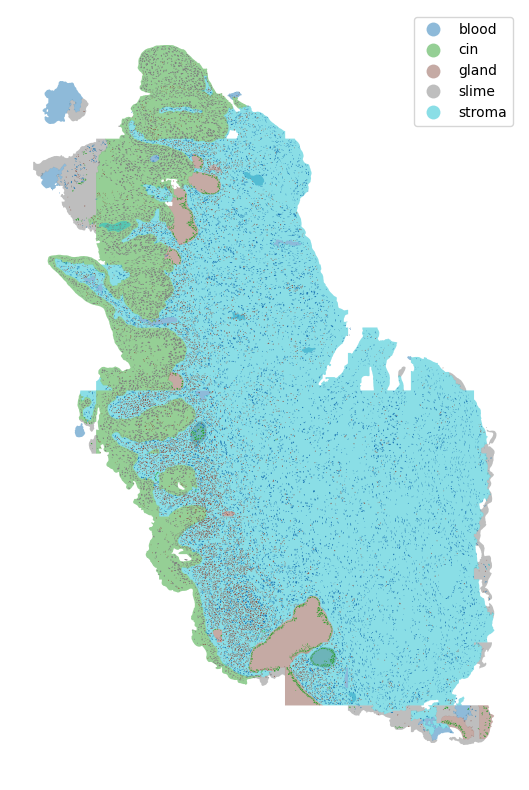

In [1]:
# Let's load some data to play around with
import matplotlib.pyplot as plt
from histolytics.data import cervix_nuclei, cervix_tissue

tis = cervix_tissue()
nuc = cervix_nuclei()

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=False)
ax.set_axis_off()

### Density Based Clustering

In this tutorial, we will use the DBSCAN algorithm to cluster the inflammatory cells that often form spatial clusters in the tissue. The DBSCAN algorithm is a density-based clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions. We will use the `density_clustering`-function which is a wrapper around different density based clustering algorithms from the sklearn and esda libraries. The available algorithms in Histolytics are `dbscan`, `hdbscan`, `adbscan`, and `optics`.

At least, the following parameters should be considered when running density based clustering algorithms:

- `min_samples`: The minimum number of samples in a neighborhood for a point to be considered as a core point.
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

,geometry,class_name,labels
14,"POLYGON ((925 5211.02, 924.01 5212, 924.01 522...",inflammatory,-1
17,"POLYGON ((899 5607.02, 898.01 5608, 898.01 561...",inflammatory,-1
22,"POLYGON ((873 5284.02, 871.01 5286, 871.01 529...",inflammatory,-1


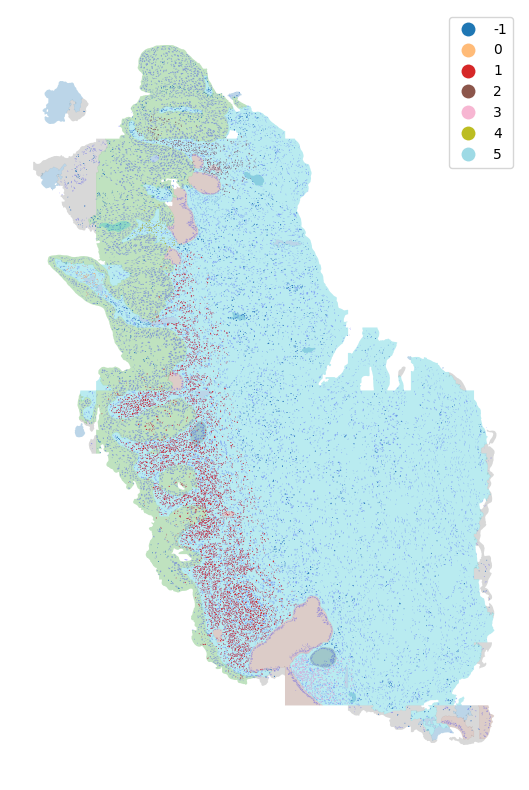

In [2]:
from histolytics.spatial_clust.density_clustering import density_clustering

nuc_imm = nuc[nuc["class_name"] == "inflammatory"]
labels = density_clustering(nuc_imm, eps=250, min_samples=50, method="dbscan")
nuc_imm = nuc_imm.assign(labels=labels)

ax = tis.plot(figsize=(10, 10), column="class_name", alpha=0.3)
ax = nuc.plot(ax=ax, color="blue", alpha=0.3, aspect=1)
nuc_imm.plot(
    ax=ax, column="labels", aspect=1, cmap="tab20", legend=True, categorical=True
)
ax.set_axis_off()
nuc_imm.head(3)

The immune cell clusters are highlighted with different colors in the image. 

### Cluster Features

Next, we will analyze these immune clusters by computing cluster features. We will first get the cluster tendencies i.e. we will extract the cluster centroids. Then we will calculate the cluster size, area, dispersion and orientation for each cluster, and finally we will plot some visualizations of the clusters. We will use the `cluster_tendency`-function to extract the cluster centroids, and then the `cluster_feats`-function to compute the size, area, dispersion and orientation of the clusters.

,labels,geometry,area,dispersion,size,orientation
1,0,POINT (886.159 7418.012),2.817947e+05,234.488171,82.0,5.482046
2,1,POINT (2759.247 3884.393),1.156891e+07,1681.809966,4272.0,75.204700
3,2,POINT (2691.992 9388.149),1.418761e+06,525.666167,412.0,21.698906
4,3,POINT (4498.243 1071.52),6.325208e+05,311.207442,311.0,14.691102
5,4,POINT (1934.696 8181.984),3.547952e+05,218.192396,95.0,21.848834
6,5,POINT (2761.256 8575.997),2.762148e+05,209.376598,79.0,14.740579


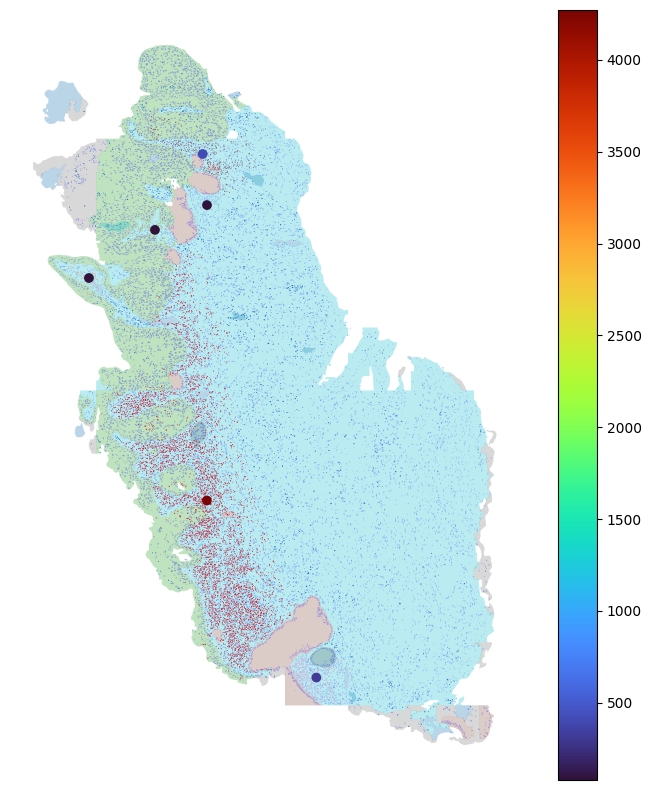

In [3]:
from histolytics.spatial_clust.centrography import cluster_tendency
from histolytics.spatial_clust.clust_metrics import cluster_feats
import pandas as pd
import geopandas as gpd

# compute cluster centroids and features, use groupby to apply the functions
# to each cluster separately
clust_centroids = (
    nuc_imm.groupby("labels")
    .apply(lambda g: cluster_tendency(g, "mean"), include_groups=False)
    .reset_index(drop=False, name="geometry")
)


clust_features = (
    nuc_imm.groupby("labels")
    .apply(
        lambda x: cluster_feats(x, hull_type="convex_hull", normalize_orientation=True),
        include_groups=False,
    )
    .reset_index(drop=False)
)

# merge the cluster centroids and features
clust_feats = clust_centroids.merge(clust_features, on="labels")

# convert to GeoDataFrame
clust_feats = gpd.GeoDataFrame(clust_feats, geometry="geometry")

# drop the noise cluster
clust_feats = clust_feats[clust_feats["labels"] != -1]

# plot the cluster centroids and the nuclei, color by the size
ax = tis.plot(figsize=(10, 10), column="class_name", alpha=0.3)
ax = nuc.plot(ax=ax, color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats.plot(ax=ax, column="size", aspect=1, cmap="turbo", legend=True)
ax.set_axis_off()
clust_feats

### Benchmark

The run-time benchmarks below show that from the included density based clustering algorithms, the DBSCAN is clearly the most performant, while the HDBSCAN run-time is still competitive. This makes these algorithms well-suited for high-throughput histopathology applications where large datasets are common. The OPTICS algorithm and ADBSCAN algorithms have some scalability issues, thus, these are not recommended for WSI-level datasets. The run-time benchmark was done with the same cervical biopsy dataset with ~19K nuclei that was used in the tutorial.

In [6]:
%%timeit
density_clustering(nuc, eps=250, min_samples=50, method="dbscan")

136 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
density_clustering(nuc, eps=250, min_samples=50, method="optics")

8.04 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
density_clustering(nuc, eps=250, min_samples=50, method="hdbscan")

1.06 s ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
density_clustering(nuc, eps=250, min_samples=50, method="adbscan")

36.1 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
